TASK 3: Handwritten Character Recognition

In [2]:
import cv2
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D, Flatten, Dense, BatchNormalization, Activation, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau, LearningRateScheduler
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import pandas as pd
from tensorflow import keras
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sn
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight
import warnings
warnings.filterwarnings(
    "ignore",
    category=UserWarning,
    message="Protobuf gencode version.*"
)
%matplotlib inline

Dataset: MNIST as Images (Train and Test)

About Dataset: The MNIST dataset is a benchmark collection of 70,000 grayscale images of handwritten digits (0–9), each 28×28 pixels, commonly used for training and evaluating deep learning models in image classification.

In [3]:
# Paths to data
train_dir = "D:/Projects/Train"
test_dir = "D:/Projects/Test"

In [ ]:
IMG_SIZE   = (64, 64)
BATCH_SIZE = 64
EPOCHS     = 30
SEED       = 42

def equalize(img):
    return img / 255.0

train_datagen = ImageDataGenerator(
    preprocessing_function=equalize,
    
    validation_split=0.2  
)

train_gen = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    seed=SEED,
    shuffle=True   
)

val_gen = train_datagen.flow_from_directory(
    directory=train_dir,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    seed=SEED,
    shuffle=False
 )

test_gen = ImageDataGenerator(
    preprocessing_function=equalize
).flow_from_directory(
    directory=test_dir,
    target_size=IMG_SIZE,
    color_mode='grayscale',
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)




Found 48004 images belonging to 10 classes.
Found 11996 images belonging to 10 classes.
Found 10000 images belonging to 10 classes.


In [5]:
num_classes = train_gen.num_classes
class_names = list(train_gen.class_indices.keys())
print("Classes:", class_names)

Classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


In [6]:
model = Sequential()

#Feature extraction
model.add(Conv2D(8, kernel_size=3, padding='same', input_shape=(64, 64, 1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(2, padding='same'))
model.add(Dropout(0.3))

model.add(Conv2D(16, kernel_size=3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(2, padding='same'))
model.add(Dropout(0.3))

model.add(Conv2D(32, kernel_size=3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(2, padding='same'))
model.add(Dropout(0.3))

model.add(Conv2D(64, kernel_size=3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(2, padding='same'))

model.add(Conv2D(128, kernel_size=3, padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPool2D(2, padding='same'))

# End of feature extraction
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))   
model.add(Dense(num_classes, activation='softmax'))  # 10 classes

# Compile
optimizer = Adam(learning_rate=5e-4)
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',   
    metrics=['accuracy',tf.keras.metrics.Recall(name='recall'), tf.keras.metrics.Precision(name='precision')]
)

# Summary
model.summary()
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)


c:\Users\SEEE\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 64, 64, 8)      │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 64, 64, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 64, 64, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 32, 32, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 32, 32, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 16, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 16, 16, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 16, 16, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 8, 8, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 8, 8, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 4, 4, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 4, 4, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 367,018 (1.40 MB)

 Trainable params: 366,522 (1.40 MB)

 Non-trainable params: 496 (1.94 KB)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [7]:
callbacks = [
    EarlyStopping(patience=15, monitor='val_loss', restore_best_weights=True, verbose=1),
    ReduceLROnPlateau(factor=0.5, patience=6, min_lr= 1e-3, verbose=1),
    ModelCheckpoint('model_bone.h5', monitor='val_loss', save_best_only=True, verbose=1)
]

labels = train_gen.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(labels),
    y=labels
)
class_weights = dict(enumerate(class_weights))

print("Class Weights:", class_weights)

# Training
hist = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    class_weight=class_weights, 
    shuffle=True,
    verbose=1
)



Class Weights: {0: np.float64(1.0129563198987128), 1: np.float64(0.8899517982944012), 2: np.float64(1.0070065030417454), 3: np.float64(0.9786748216106014), 4: np.float64(1.027043217800599), 5: np.float64(1.106848051648605), 6: np.float64(1.0138120380147835), 7: np.float64(0.957781324820431), 8: np.float64(1.0255073702200384), 9: np.float64(1.0084873949579831)}


c:\Users\SEEE\AppData\Local\Programs\Python\Python313\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
751/751 ━━━━━━━━━━━━━━━━━━━━ 0s 927ms/step - accuracy: 0.6416 - loss: 1.0859 - precision: 0.7756 - recall: 0.5503
Epoch 1: val_loss improved from None to 0.45193, saving model to model_bone.h5


751/751 ━━━━━━━━━━━━━━━━━━━━ 865s 1s/step - accuracy: 0.8072 - loss: 0.5832 - precision: 0.8850 - recall: 0.7621 - val_accuracy: 0.8564 - val_loss: 0.4519 - val_precision: 0.8748 - val_recall: 0.8419 - learning_rate: 5.0000e-04
Epoch 2/30
751/751 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.9341 - loss: 0.2101 - precision: 0.9447 - recall: 0.9263
Epoch 2: val_loss improved from 0.45193 to 0.16393, saving model to model_bone.h5


751/751 ━━━━━━━━━━━━━━━━━━━━ 92s 122ms/step - accuracy: 0.9410 - loss: 0.1891 - precision: 0.9502 - recall: 0.9340 - val_accuracy: 0.9488 - val_loss: 0.1639 - val_precision: 0.9572 - val_recall: 0.9423 - learning_rate: 5.0000e-04
Epoch 3/30
751/751 ━━━━━━━━━━━━━━━━━━━━ 0s 113ms/step - accuracy: 0.9520 - loss: 0.1484 - precision: 0.9586 - recall: 0.9466
Epoch 3: val_loss improved from 0.16393 to 0.15159, saving model to model_bone.h5


751/751 ━━━━━━━━━━━━━━━━━━━━ 94s 125ms/step - accuracy: 0.9567 - loss: 0.1367 - precision: 0.9622 - recall: 0.9521 - val_accuracy: 0.9555 - val_loss: 0.1516 - val_precision: 0.9613 - val_recall: 0.9503 - learning_rate: 5.0000e-04
Epoch 4/30
751/751 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9637 - loss: 0.1160 - precision: 0.9684 - recall: 0.9598
Epoch 4: val_loss improved from 0.15159 to 0.07803, saving model to model_bone.h5


751/751 ━━━━━━━━━━━━━━━━━━━━ 93s 123ms/step - accuracy: 0.9662 - loss: 0.1097 - precision: 0.9705 - recall: 0.9628 - val_accuracy: 0.9755 - val_loss: 0.0780 - val_precision: 0.9791 - val_recall: 0.9727 - learning_rate: 5.0000e-04
Epoch 5/30
751/751 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9685 - loss: 0.0979 - precision: 0.9725 - recall: 0.9655
Epoch 5: val_loss improved from 0.07803 to 0.05825, saving model to model_bone.h5


751/751 ━━━━━━━━━━━━━━━━━━━━ 90s 120ms/step - accuracy: 0.9697 - loss: 0.0960 - precision: 0.9738 - recall: 0.9667 - val_accuracy: 0.9817 - val_loss: 0.0582 - val_precision: 0.9842 - val_recall: 0.9799 - learning_rate: 5.0000e-04
Epoch 6/30
751/751 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9732 - loss: 0.0854 - precision: 0.9763 - recall: 0.9704
Epoch 6: val_loss improved from 0.05825 to 0.04111, saving model to model_bone.h5


751/751 ━━━━━━━━━━━━━━━━━━━━ 88s 117ms/step - accuracy: 0.9730 - loss: 0.0869 - precision: 0.9760 - recall: 0.9703 - val_accuracy: 0.9873 - val_loss: 0.0411 - val_precision: 0.9894 - val_recall: 0.9853 - learning_rate: 5.0000e-04
Epoch 7/30
751/751 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9758 - loss: 0.0802 - precision: 0.9783 - recall: 0.9731
Epoch 7: val_loss improved from 0.04111 to 0.04092, saving model to model_bone.h5


751/751 ━━━━━━━━━━━━━━━━━━━━ 88s 118ms/step - accuracy: 0.9764 - loss: 0.0776 - precision: 0.9791 - recall: 0.9738 - val_accuracy: 0.9872 - val_loss: 0.0409 - val_precision: 0.9886 - val_recall: 0.9861 - learning_rate: 5.0000e-04
Epoch 8/30
751/751 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9778 - loss: 0.0710 - precision: 0.9803 - recall: 0.9763
Epoch 8: val_loss improved from 0.04092 to 0.02936, saving model to model_bone.h5


751/751 ━━━━━━━━━━━━━━━━━━━━ 89s 119ms/step - accuracy: 0.9781 - loss: 0.0703 - precision: 0.9807 - recall: 0.9762 - val_accuracy: 0.9900 - val_loss: 0.0294 - val_precision: 0.9912 - val_recall: 0.9886 - learning_rate: 5.0000e-04
Epoch 9/30
751/751 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9781 - loss: 0.0717 - precision: 0.9807 - recall: 0.9764
Epoch 9: val_loss did not improve from 0.02936
751/751 ━━━━━━━━━━━━━━━━━━━━ 89s 118ms/step - accuracy: 0.9791 - loss: 0.0667 - precision: 0.9815 - recall: 0.9773 - val_accuracy: 0.9876 - val_loss: 0.0424 - val_precision: 0.9891 - val_recall: 0.9864 - learning_rate: 5.0000e-04
Epoch 10/30
751/751 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step - accuracy: 0.9811 - loss: 0.0593 - precision: 0.9832 - recall: 0.9793
Epoch 10: val_loss did not improve from 0.02936
751/751 ━━━━━━━━━━━━━━━━━━━━ 90s 120ms/step - accuracy: 0.9812 - loss: 0.0598 - precision: 0.9832 - recall: 0.9794 - val_accuracy: 0.9856 - val_loss: 0.0475 - val_precision: 0.9869 - val_recall:

751/751 ━━━━━━━━━━━━━━━━━━━━ 93s 123ms/step - accuracy: 0.9863 - loss: 0.0432 - precision: 0.9877 - recall: 0.9852 - val_accuracy: 0.9930 - val_loss: 0.0231 - val_precision: 0.9937 - val_recall: 0.9926 - learning_rate: 5.0000e-04
Epoch 17/30
751/751 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.9882 - loss: 0.0393 - precision: 0.9892 - recall: 0.9871
Epoch 17: val_loss improved from 0.02314 to 0.02241, saving model to model_bone.h5


751/751 ━━━━━━━━━━━━━━━━━━━━ 89s 119ms/step - accuracy: 0.9871 - loss: 0.0421 - precision: 0.9881 - recall: 0.9860 - val_accuracy: 0.9930 - val_loss: 0.0224 - val_precision: 0.9936 - val_recall: 0.9926 - learning_rate: 5.0000e-04
Epoch 18/30
751/751 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.9858 - loss: 0.0428 - precision: 0.9868 - recall: 0.9847
Epoch 18: val_loss improved from 0.02241 to 0.02058, saving model to model_bone.h5


751/751 ━━━━━━━━━━━━━━━━━━━━ 98s 130ms/step - accuracy: 0.9865 - loss: 0.0415 - precision: 0.9878 - recall: 0.9854 - val_accuracy: 0.9940 - val_loss: 0.0206 - val_precision: 0.9947 - val_recall: 0.9936 - learning_rate: 5.0000e-04
Epoch 19/30
751/751 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.9877 - loss: 0.0383 - precision: 0.9886 - recall: 0.9866
Epoch 19: val_loss did not improve from 0.02058
751/751 ━━━━━━━━━━━━━━━━━━━━ 110s 147ms/step - accuracy: 0.9874 - loss: 0.0394 - precision: 0.9883 - recall: 0.9865 - val_accuracy: 0.9922 - val_loss: 0.0247 - val_precision: 0.9932 - val_recall: 0.9917 - learning_rate: 5.0000e-04
Epoch 20/30
751/751 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.9893 - loss: 0.0346 - precision: 0.9906 - recall: 0.9884
Epoch 20: val_loss did not improve from 0.02058
751/751 ━━━━━━━━━━━━━━━━━━━━ 112s 149ms/step - accuracy: 0.9894 - loss: 0.0356 - precision: 0.9904 - recall: 0.9886 - val_accuracy: 0.9916 - val_loss: 0.0263 - val_precision: 0.9927 - val_rec

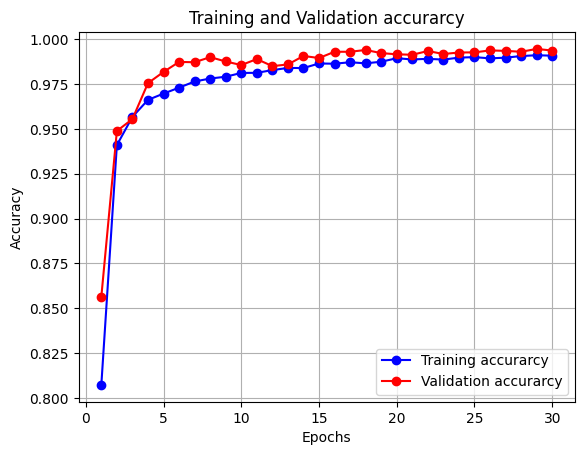

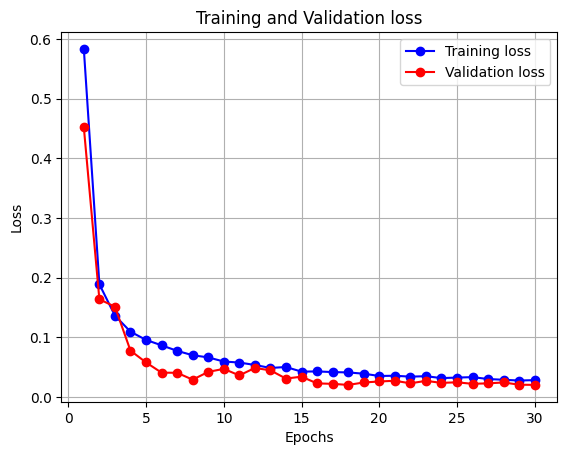

In [8]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
loss = hist.history['loss']
val_loss = hist.history['val_loss']
epochs = range(1, len(acc) + 1)

#Train and validation accuracy
plt.figure()
plt.plot(epochs, acc, 'b-o', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r-o', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b-o', label='Training loss')
plt.plot(epochs, val_loss, 'r-o', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [9]:
y_test = []
y_test_int = []
for i in tqdm(range(len(test_gen))):
    y_test += test_gen[i][1].tolist()
    y_test_int += test_gen[i][1].argmax(axis=1).tolist()
y_test = np.array(y_test)
y_test_int = np.array(y_test_int)

100%|██████████| 157/157 [02:18<00:00,  1.13it/s]


In [10]:
y_pred_test = model.predict(test_gen, verbose=1)
y_pred_test_int = y_pred_test.argmax(axis=1)

157/157 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step


              precision    recall  f1-score   support

           0     0.9899    0.9969    0.9934       980
           1     0.9956    0.9991    0.9974      1135
           2     0.9980    0.9884    0.9932      1032
           3     0.9921    0.9960    0.9941      1010
           4     0.9929    0.9949    0.9939       982
           5     0.9921    0.9899    0.9910       892
           6     0.9979    0.9843    0.9911       958
           7     0.9808    0.9961    0.9884      1028
           8     0.9949    0.9918    0.9933       974
           9     0.9910    0.9861    0.9886      1009

    accuracy                         0.9925     10000
   macro avg     0.9925    0.9924    0.9924     10000
weighted avg     0.9925    0.9925    0.9925     10000



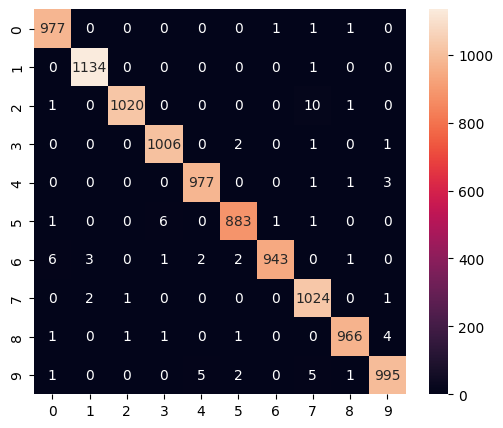

In [11]:
cm = confusion_matrix(y_test_int, y_pred_test_int)
plt.figure(figsize=(6,5))
sn.heatmap(cm,annot=True,fmt="d",xticklabels=class_names, yticklabels=class_names)

print(classification_report(y_test_int, y_pred_test_int, target_names=class_names,digits=4))

In [12]:
print("Accuracy:",accuracy_score(y_test_int, y_pred_test_int))

Accuracy: 0.9925


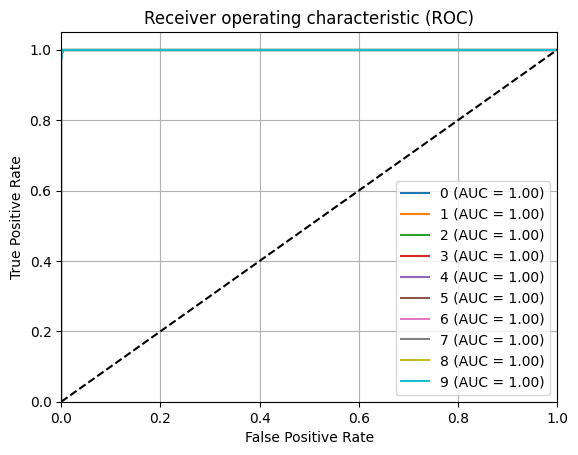

In [13]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_test.shape[1]
plt.figure()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred_test[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    plt.plot(fpr[i], tpr[i], label=f'{class_names[i]} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

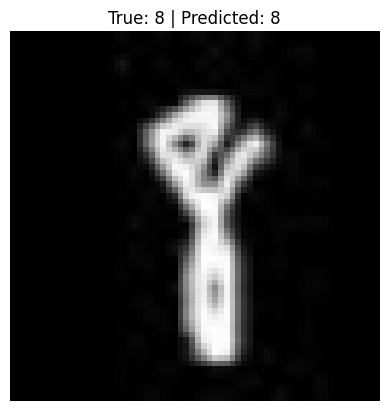

Prediction Probabilities (per class):
  0                   : 0.0008
  1                   : 0.3534
  2                   : 0.0007
  3                   : 0.0006
  4                   : 0.0920
  5                   : 0.0005
  6                   : 0.0001
  7                   : 0.0160
  8                   : 0.4509
  9                   : 0.0851


In [17]:
image_path = "D:/Projects/Train/8/720.jpg"
img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError(f"Image not found: {image_path}")

img_resized = cv2.resize(img, IMG_SIZE)
img_input   = img_resized.reshape(1, IMG_SIZE[0], IMG_SIZE[1], 1).astype('float32') / 255.0

pred = model.predict(img_input, verbose=0)
pred_class_idx = int(np.argmax(pred))
pred_class_name = class_names[pred_class_idx]

true_label = os.path.basename(os.path.dirname(image_path))

plt.imshow(img_resized, cmap='gray')
plt.title(f"True: {true_label} | Predicted: {pred_class_name}")
plt.axis("off")
plt.show()

print("Prediction Probabilities (per class):")
for name, p in zip(class_names, pred[0]):
    print(f"  {name:<20s}: {p:.4f}")